<a href="https://colab.research.google.com/github/pavithra64/Fake-news-detection/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Importing libraries
import os
import re
import joblib
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, auc


# xgboost
import xgboost as xgb

# shap
import shap

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Set the NLTK data path explicitly
nltk.data.path.append('/root/nltk_data')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Check if punkt is available after download
try:
    nltk.data.find('tokenizers/punkt')
    print("NLTK punkt resource found.")
except nltk.downloader.DownloadError as e:
    print(f"Error downloading NLTK punkt resource: {e}")
except LookupError:
    print("NLTK punkt resource not found after download attempt. There might be an environment issue.")


warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

NLTK punkt resource found.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
#  Config & Helpers

DATA_PATH = "fake_news_data.csv"
MODEL_OUTPUT = "fake_news_model.joblib"
PREPROCESSOR_OUTPUT = "preprocessor.joblib"

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    """Lowercase, remove URLs, non-alpha, tokenize, remove stopwords, and lemmatize."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    # Explicitly load the punkt tokenizer
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues")
    plt.title(title)
    plt.show()

def plot_roc(y_true, y_proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr,tpr):.3f}')
    plt.plot([0,1],[0,1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend(); plt.show()

In [19]:
# Load & EDA
# ---------------------
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print(df.columns.tolist())
print(df.head(2))



Shape: (198, 4)
['title', 'text', 'date', 'fake_or_factual']
                                               title  \
0  HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...   
1   Elijah Cummings Called Trump Out To His Face ...   

                                                text           date  \
0  There are two small problems with your analogy...   Dec 30, 2015   
1  Buried in Trump s bonkers interview with New Y...  April 6, 2017   

  fake_or_factual  
0       Fake News  
1       Fake News  


In [20]:
# Ensure label column exists — map 'fake_or_factual' to binary label
if 'fake_or_factual' not in df.columns:
    raise ValueError("Expected 'fake_or_factual' column as target. Adjust dataset or mapping.")

# map values; adapt mapping to your dataset values
# Assuming 'Fake News' is the positive class (1) and 'Factual News' is the negative class (0)
label_map = {'Fake News': 1, 'Factual News': 0}
df['label'] = df['fake_or_factual'].map(label_map)



In [21]:
# Handle potential missing values after mapping (if any unexpected values were present)
if df['label'].isnull().any():
    print("Warning: Some values in 'fake_or_factual' did not match the mapping and resulted in NaN in 'label'.")
    print("Unique 'fake_or_factual' values not in mapping:", df[df['label'].isnull()]['fake_or_factual'].unique())
    # Optionally, drop rows with NaN labels or handle them differently
    # df.dropna(subset=['label'], inplace=True)
    # print("Rows with NaN labels dropped.")

print(df['label'].value_counts())

label
0    100
1     98
Name: count, dtype: int64


In [22]:
# Basic cleaning of text/title
df['text'] = df['text'].fillna("")
df['title'] = df['title'].fillna("")
# df['author'] = df['author'].fillna("unknown") # Removed as column not present
# df['site_url'] = df['site_url'].fillna("unknown") # Removed as column not present
# df['language'] = df['language'].fillna("unknown") # Removed as column not present
# df['country'] = df['country'].fillna("unknown") # Removed as column not present

# parse published date
df['published'] = pd.to_datetime(df['date'], errors='coerce') # Corrected column name to 'date'

# quick stats
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))
print("Word count stats:", df['word_count'].describe())

Word count stats: count     198.000000
mean      375.141414
std       309.665826
min        13.000000
25%       166.500000
50%       343.000000
75%       478.000000
max      3141.000000
Name: word_count, dtype: float64


In [24]:
# Preprocessing & Feature Engineering
# ---------------------
# Create cleaned content (title + text)
df['clean_text'] = df['text'].apply(clean_text)
df['clean_title'] = df['title'].apply(clean_text)
df['content'] = (df['clean_title'] + " " + df['clean_text']).str.strip()

# Numeric metadata (fillna and coerce)
# Updated num_cols to only include available numeric-like column
num_cols = ['word_count']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
    else:
        # This else block is technically not needed now that we filtered num_cols,
        # but keeping for robustness if num_cols were dynamic
        df[c] = 0

# Remove author cardinality reduction code as 'author' column is not present
# top_k_authors = 50
# top_authors = df['author'].value_counts().nlargest(top_k_authors).index.tolist()
# df['author_top'] = df['author'].where(df['author'].isin(top_authors), other='other')

# temporal features - only use if 'published' was successfully created and has non-nulls
if 'published' in df.columns and not df['published'].isnull().all():
    df['pub_hour'] = df['published'].dt.hour.fillna(-1).astype(int)
    df['pub_dayofweek'] = df['published'].dt.dayofweek.fillna(-1).astype(int)
    # Update meta_cat to include temporal features if created
    meta_cat = ['pub_hour','pub_dayofweek']
else:
    # If 'published' is not available or all null, temporal features cannot be created
    meta_cat = []
    print("Warning: 'published' column not available or all null. Temporal features 'pub_hour' and 'pub_dayofweek' were not created.")


# Prepare feature matrix and target
feature_text = 'content'
# Updated meta_num and meta_cat to reflect available features
meta_num = ['word_count']
# meta_cat is set based on whether temporal features were created

# Filter X based on available columns
available_cols = [feature_text] + meta_num + meta_cat
X = df[available_cols].copy()
y = df['label'].copy()

In [25]:
#  Train / Test split (STRATIFY!)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train label counts:\n", y_train.value_counts())
print("Test label counts:\n", y_test.value_counts())

# -

Train label counts:
 label
0    80
1    78
Name: count, dtype: int64
Test label counts:
 label
0    20
1    20
Name: count, dtype: int64


In [26]:
# Preprocessor & pipeline

# TF-IDF for text; keep moderate max_features
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=5)

# numeric scaler
num_transform = StandardScaler()

# categorical encoder - use sparse output to keep memory small
cat_transform = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, feature_text),
        ('num', num_transform, meta_num),
        ('cat', cat_transform, meta_cat),
    ],
    remainder='drop',
    sparse_threshold=0.3
)

Fitting baseline logistic regression ...
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        20
           1       1.00      0.60      0.75        20

    accuracy                           0.80        40
   macro avg       0.86      0.80      0.79        40
weighted avg       0.86      0.80      0.79        40

Baseline ROC AUC: 0.9850000000000001


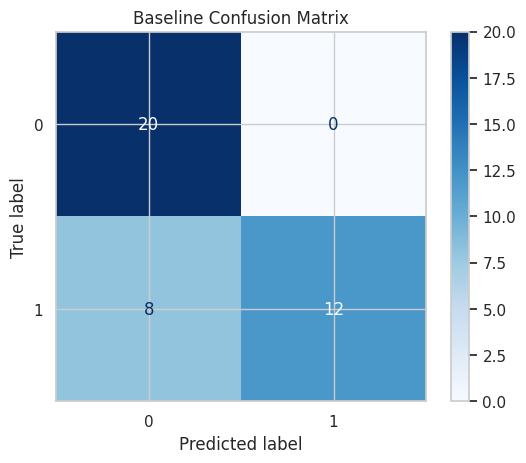

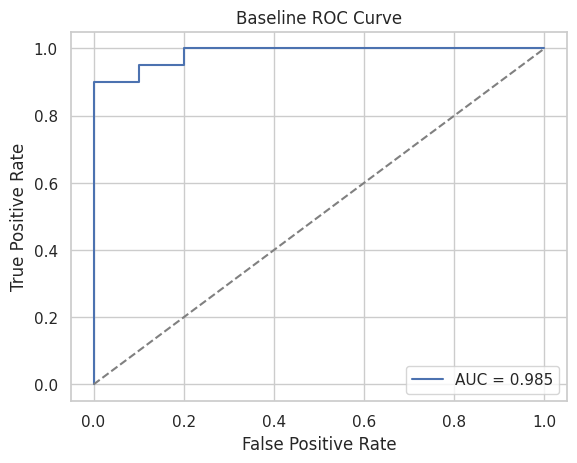

In [27]:
#  Baseline: Logistic Regression pipeline

baseline_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga', n_jobs=-1))
])

print("Fitting baseline logistic regression ...")
baseline_pipe.fit(X_train, y_train)

y_pred = baseline_pipe.predict(X_test)
y_proba = baseline_pipe.predict_proba(X_test)[:,1]

print("Baseline Classification Report:")
print(classification_report(y_test, y_pred))
print("Baseline ROC AUC:", roc_auc_score(y_test, y_proba))

plot_confusion(y_test, y_pred, title="Baseline Confusion Matrix")
plot_roc(y_test, y_proba, title="Baseline ROC Curve")

Transforming features for XGBoost training (may produce sparse matrix)...
scale_pos_weight: 1.0256410256410255
Running GridSearchCV for XGBoost (this may take time)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

XGBoost ROC AUC: 1.0


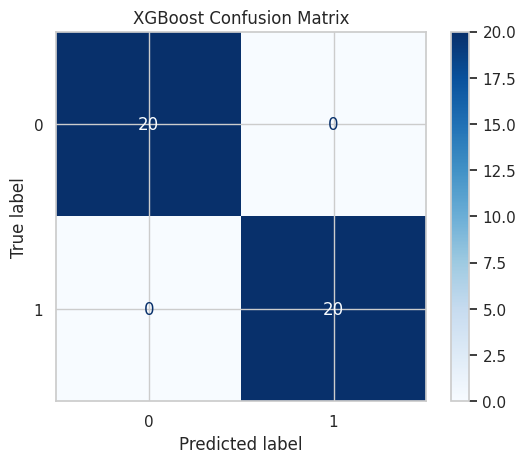

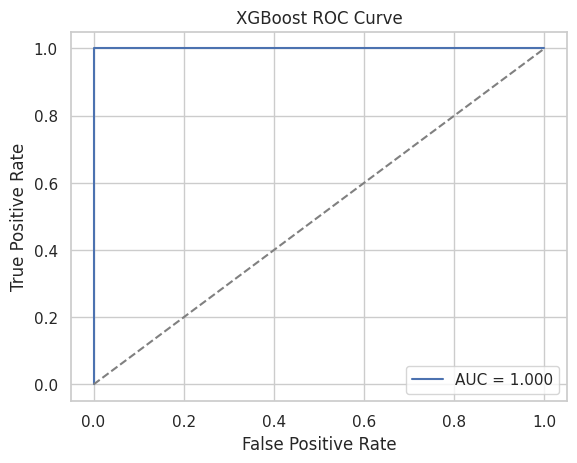

In [30]:
# Improved model: XGBoost (use scale_pos_weight for imbalance)

# transform training data into arrays for XGBoost
print("Transforming features for XGBoost training (may produce sparse matrix)...")
X_train_trans = preprocessor.fit_transform(X_train)   # fit preprocessor here for final model
X_test_trans = preprocessor.transform(X_test)

# XGBoost expects dense arrays for many operations; but can accept sparse CSR as well.
# We'll use sparse if it's sparse, else convert to array.
if hasattr(X_train_trans, "toarray"):
    X_train_mat = X_train_trans  # sparse CSR OK for xgboost
    X_test_mat = X_test_trans
else:
    X_train_mat = np.asarray(X_train_trans)
    X_test_mat = np.asarray(X_test_trans)

# compute scale_pos_weight = neg/pos
pos = (y_train==1).sum()
neg = (y_train==0).sum()
scale_pos_weight = neg / max(1, pos)
print("scale_pos_weight:", scale_pos_weight)

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_jobs=4,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    base_score=0.5 # Explicitly setting base_score
)

# quick param grid (short)
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [4, 7],
    'learning_rate': [0.1, 0.01]
}

grid = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='f1', verbose=1, n_jobs=2)
print("Running GridSearchCV for XGBoost (this may take time)...")
grid.fit(X_train_mat, y_train)

print("Best XGBoost params:", grid.best_params_)
best_xgb = grid.best_estimator_

# Evaluate
y_pred_xgb = best_xgb.predict(X_test_mat)
y_proba_xgb = best_xgb.predict_proba(X_test_mat)[:,1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test, y_proba_xgb))

plot_confusion(y_test, y_pred_xgb, title="XGBoost Confusion Matrix")
plot_roc(y_test, y_proba_xgb, title="XGBoost ROC Curve")

In [32]:
# Save final objects for deployment

print("Saving model and preprocessor ...")
joblib.dump(best_xgb, MODEL_OUTPUT)
joblib.dump(preprocessor, PREPROCESSOR_OUTPUT)
print("Saved:", MODEL_OUTPUT, PREPROCESSOR_OUTPUT)

# Also save baseline for reference
joblib.dump(baseline_pipe, "baseline_pipe.joblib")


Saving model and preprocessor ...
Saved: fake_news_model.joblib preprocessor.joblib


['baseline_pipe.joblib']

In [33]:
#  Quick predict helper

def predict_article(title: str, text: str, **meta):
    content = (clean_text(title or "") + " " + clean_text(text or "")).strip()
    row = {feature_text: content}
    for c in meta_num: row[c] = meta.get(c, 0)
    for c in meta_cat: row[c] = meta.get(c, 'unknown')
    X_row = pd.DataFrame([row])
    X_trans = preprocessor.transform(X_row)
    # to dense if needed
    if hasattr(X_trans, "toarray"):
        X_mat = X_trans
    else:
        X_mat = np.asarray(X_trans)
    proba = best_xgb.predict_proba(X_mat)[:,1][0]
    pred = int(proba > 0.5)
    return pred, proba

In [34]:
# Example
print("Example prediction (dummy):", predict_article("Breaking", "This is a sample article about something."))#1 implies fake and 0 real

if __name__ == "__main__":
    print("Pipeline finished successfully.")


Example prediction (dummy): (1, np.float32(0.9915104))
Pipeline finished successfully.


**Interpretation:**

The model predicts the article is FAKE (label 1) with ~99.1% confidence.